## Churn Prediction Assessment - Final Model Training

After using machine learning techniques to select the best model and tune its parameters, we are now ready to move forward with production. However, before doing so, the plan is to leverage the full dataset to train the model. At this stage, there is no longer a need to maintain a split between training and testing data, as the focus has shifted away from estimating the model’s error on unseen data. We now have what we believe is the best model, one that has been properly tuned to generalize well to new, unseen data.

#### **General Set-Up**

In [12]:
# Import required libraries
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, average_precision_score

In [13]:
# Read parquet
df = pd.read_parquet("../data/processed/churn_prediction_dataset.parquet")
df.head()

,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_anual,mcomisiones,mactivos_margen,mpasivos_margen,cant_total_prod,...,visa_mconsumototal,visa_cconsumos,visa_mpagominimo,clase_binaria,visa_tenure_days,tcuentas_2,visa_cuenta_estado_11.0,visa_cuenta_estado_12.0,visa_cuenta_estado_19.0,visa_cuenta_estado_0.0
0,0,1,44,72,3296.69,14455.27,579.66,910.65,1411.60,11,...,14555.47,13.0,3837.6,0,4473.0,False,False,False,False,False
1,0,0,78,159,1032.18,10141.18,790.58,71.21,135.29,6,...,-11.55,2.0,35.1,0,7129.0,False,False,False,False,False
2,0,1,64,299,-52.34,4752.64,236.08,-422.18,175.66,7,...,6788.67,4.0,1977.3,0,10584.0,False,False,False,False,False
3,0,1,48,282,485.91,10676.87,1280.47,-1275.18,596.07,8,...,2946.70,5.0,573.3,0,3848.0,False,False,False,False,False
4,0,1,45,171,5878.27,24298.75,64.38,22.11,4947.03,9,...,1048.32,1.0,128.7,0,7501.0,False,False,False,False,False


In [14]:
# Features and target
X = df.drop(columns = ["clase_binaria"])
y = df["clase_binaria"]

#### **Final Model Training And Quick Validation**

In [15]:
# Final Model with manually chosen hyperparameters
final_xgb = xgb.XGBClassifier(
    subsample = 1.0,
    scale_pos_weight = 92.036104,
    n_estimators = 300,
    min_child_weight = 5,
    max_depth = 10,
    learning_rate = 0.10,
    colsample_bytree = 0.7,
    eval_metric = "logloss",
    random_state = 12,
    n_jobs = -1
)

# Fit the model on the full dataset
final_xgb.fit(X, y)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Since we are training the final model on the entire dataset to prepare it for production, we validate the metrics on the full dataset simply to ensure everything is working as expected. This step helps confirm that the model is performing well before being deployed to handle unseen data.

In [16]:
# Obtain the prediction probabilities for the positive class (class 1)
y_prob = final_xgb.predict_proba(X)[:, 1]

In [17]:
# Apply the threshold of 0.2
y_pred_threshold = (y_prob >= 0.2).astype(int)

In [18]:
# Display the classification report
print(classification_report(y, y_pred_threshold))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    168887
           1       0.50      1.00      0.67      1835

    accuracy                           0.99    170722
   macro avg       0.75      0.99      0.83    170722
weighted avg       0.99      0.99      0.99    170722



We’re aware that these metrics, though useful for a quick sanity check, do not provide valid conclusions about the model’s performance in production. This is not an evaluation of the final threshold’s effectiveness—it's simply a step to confirm that the model, after training on the full dataset, is working as expected. The real test will come when the model is deployed and handles new, unseen data in a production environment.

100%|===================| 170689/170722 [47:33<00:00]        

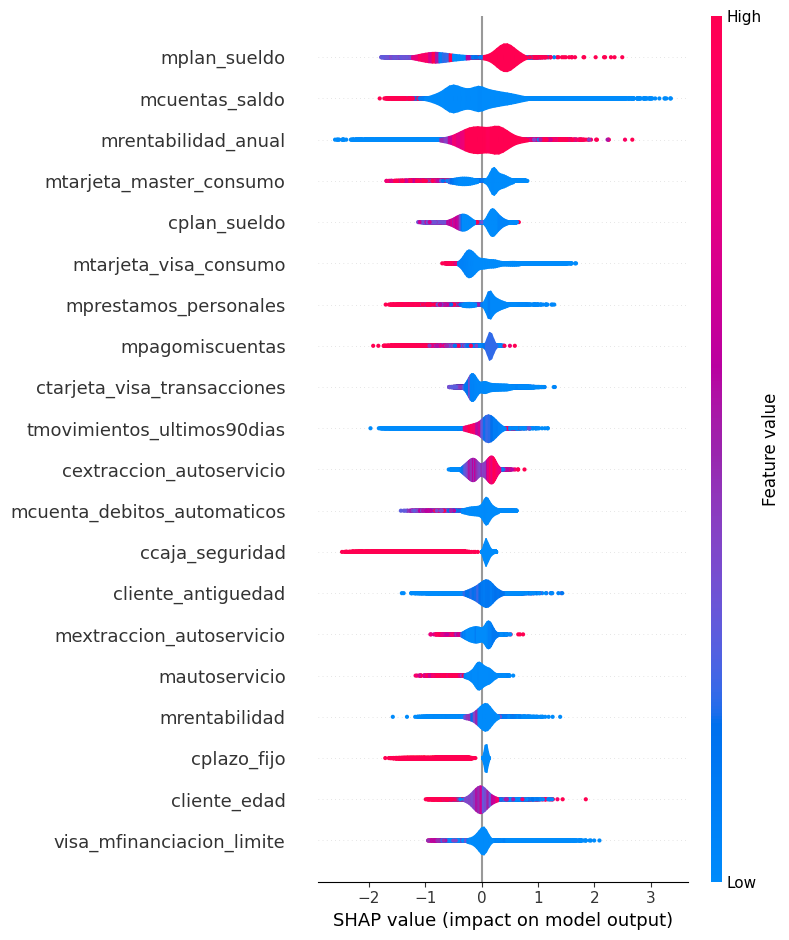

In [ ]:
# Import SHAP library
import shap

# Prepare the dataset for SHAP (convert boolean columns to 0/1 integers)
# Tree-based models like SHAP expect numeric inputs, so we convert booleans to integers for consistency
X_shap = X.copy()
bool_columns = X_shap.select_dtypes(include = ['bool', 'boolean']).columns
if len(bool_columns) > 0:
    X_shap[bool_columns] = X_shap[bool_columns].astype('int64')

# Create a SHAP explainer for the already trained model
explainer = shap.Explainer(final_xgb, X_shap)  # Using the trained model
sv_all = explainer(X_shap)  # Compute SHAP values for all rows in the dataset

# Visualize the global feature importance using a violin plot (based on the SHAP values from the full dataset)
shap.summary_plot(sv_all, X_shap, plot_type = "violin", max_display = 20)

#### **Save Pickle File**

In [19]:
# Import libraries
import pickle
import os

In [21]:
# Define the folder path
# Home directory
home_dir = os.path.expanduser("~")

# Full path to the folder
model_folder = os.path.join(home_dir, "Desktop", "bank-churn-prediction", "final_model")

# Create the folder if it doesn't exist
os.makedirs(model_folder, exist_ok=True)


# Threshold and model package
threshold = 0.2  # the classification threshold we used

model_package = {
    'model': final_xgb,      # trained XGBoost model
    'threshold': threshold   # threshold for classifying positive class
}


# Save the pickle
model_path = os.path.join(model_folder, "final_xgb_model_with_threshold.pkl")

with open(model_path, 'wb') as f:
    pickle.dump(model_package, f)